Estimating error characteristics of the MOSAiC GPS buoys

In [48]:
# Package imports
import numpy as np
import os
import pandas as pd
import proplot as pplt
import sys
from scipy.spatial.distance import cdist
sys.path.append('../../drifter/')
import utilities.cleaning as clean
import utilities.interpolation as interp

# Folder with the drift tracks from 
# the Arctic Data Center (Bliss et al. 2021)
# https://arcticdata.io/catalog/view/urn%3Auuid%3A2b859a39-cada-4147-819a-dc222f6f89a3
dataloc = '../../data/adc_dn_tracks/'

# Read in the files, including the metadata file
metadata = pd.read_csv(dataloc + 'DN_buoy_list_v2.csv')
metadata['filename'] = ['_'.join([x, str(y), z]) for 
                        x, y, z in zip(metadata['DN Station ID'],
                                       metadata['IMEI'],
                                       metadata['Sensor ID'])]
files = os.listdir(dataloc)
files = [f for f in files if f.split('.')[-1] == 'csv']
files = [f for f in files if f.split('_')[0] != 'DN']

file_present = np.array([f + '.csv' in files for f in metadata.filename])
metadata = metadata.loc[file_present].copy()
metadata.set_index('Sensor ID', inplace=True)


buoy_data = {}
freq = []
buoys = []
for file in files:
    data = pd.read_csv(dataloc + file, index_col='datetime', parse_dates=True)
    buoy = file.replace('.csv', '').split('_')[-1]
    buoy_data[buoy] = interp.regrid_buoy_track(data, precision='10min').dropna().loc[:,
            ['longitude', 'latitude', 'x_stere', 'y_stere', 'sigma_x_regrid']]

In [49]:
l1_buoys = list(metadata.loc[metadata['DN Station ID'] == 'L1'].index)

In [50]:
# Version 1: use stereographic coordinate system. Possibly more accurate later to use geodetic.
get_df = lambda v: pd.DataFrame({b: buoy_data[b][v] for b in buoy_data})
df_x = get_df('x_stere').loc[:, l1_buoys]
df_y = get_df('y_stere').loc[:, l1_buoys]

In [51]:
def pairwise_dist(b1, b2, data_x, data_y):
    """Euclidean distance between b1 and b2"""
    dfx = data_x.loc[:, [b1, b2]].dropna()
    dfy = data_y.loc[:, [b1, b2]].dropna()    
    return np.sqrt((dfx[b1] - dfx[b2])**2 - (dfy[b1] - dfy[b2])**2)
        
    
d = pairwise_dist('2019R8', '2019S92', df_x, df_y)

/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


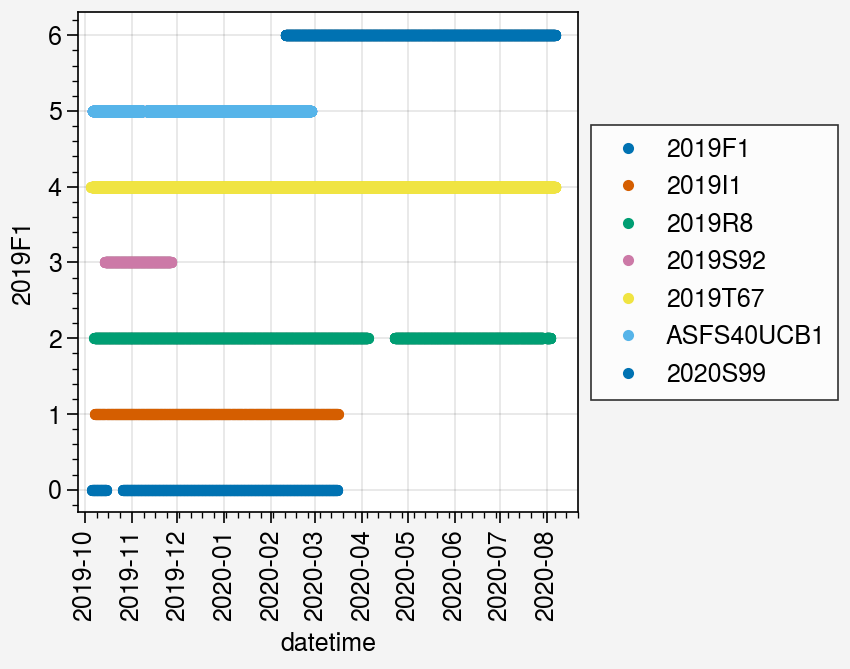

In [52]:
fig, ax = pplt.subplots()
for idx, b in enumerate(df_x.columns):
    ax.plot(idx + df_x[b]*0, lw=0, marker='.', label=b)
ax.legend(loc='r', ncols=1)

At site L1, we have 2019F1 on the half hour, 2019I1 on the hour, 2019R8 on the hour, 2019S92 every hour, 2019T67 every 30 min, and 2020S99 on the hour. S92 is only available until late Nov, and 2020S99 is only available after February.

In [64]:
pairs = [('2019F1', '2019T67'),
         ('2019I1', '2019R8'),
         ('2019I1', '2019S92'),
         ('2019I1', '2019T67'),
         ('2019I1', '2020S99'),
         ('2019R8', '2019S92'),
         ('2019R8', '2019T67'),
         ('2019R8', '2020S99'),
         ('2019S92', '2019T67'),
         ('2019T67', '2020S99')]
for p in pairs:
    b1, b2 = p
    d = pairwise_dist(b1, b2, df_x, df_y)
    print(p, len(d))

('2019F1', '2019T67') 1211
('2019I1', '2019R8') 930
('2019I1', '2019S92') 248
('2019I1', '2019T67') 929
('2019I1', '2020S99') 204
('2019R8', '2019S92') 1043
('2019R8', '2019T67') 6731
('2019R8', '2020S99') 3704
('2019S92', '2019T67') 1043
('2019T67', '2020S99') 4267


/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/drifter/lib/python3.9/site-pa

In [63]:
df_x.loc[:,'2019S92'].dropna()

datetime
2019-10-14 07:00:00     14562.70721
2019-10-14 08:00:00     14699.80368
2019-10-14 09:00:00     14875.72370
2019-10-14 10:00:00     15111.49550
2019-10-14 11:00:00     15377.34401
                           ...     
2019-11-26 13:00:00    126290.06103
2019-11-26 14:00:00    126660.77370
2019-11-26 15:00:00    127039.60849
2019-11-26 16:00:00    127408.80735
2019-11-26 17:00:00    127768.36830
Name: 2019S92, Length: 1044, dtype: float64

In [10]:
dataloc = '../data/mosaic_interpolated/'
files = os.listdir(dataloc)
files = [f for f in files if f.split('.')[-1] == 'csv']
files = [f for f in files if f.split('_')[0] != 'DN']

buoy_data_interp = {}
for file in files:
    data = pd.read_csv(dataloc + file, index_col='datetime', parse_dates=True)
    
    buoy = file.replace('.csv', '').split('_')[-1]
    
    buoy_data_interp[buoy] = data.copy()
    



In [11]:
df_x = pd.DataFrame({buoy: buoy_data_interp[buoy]['x'] for buoy in buoy_data})
df_y = pd.DataFrame({buoy: buoy_data_interp[buoy]['y'] for buoy in buoy_data})

In [12]:
timeslice = slice('2019-11-01 00:00', '2019-11-15 00:00')
X = df_x.loc[timeslice].median().dropna()
Y = df_y.loc[timeslice].median().dropna()

In [13]:
X = np.array([df_x.iloc[10,:].fillna(0), df_y.iloc[10,:].fillna(0)]).T

In [14]:
from scipy.spatial import distance_matrix
dist = distance_matrix(X, X, p=2)
dist = pd.DataFrame(data=dist, columns=df_x.columns, index=df_x.columns)

In [16]:
site_buoys = {}
for name, group in metadata.loc[dist.index].groupby('DN Station ID'):
    if name[0] == 'P':
        name = 'P'
    site_buoys[name] = group.index.to_list()

<AxesSubplot:xlabel='datetime'>

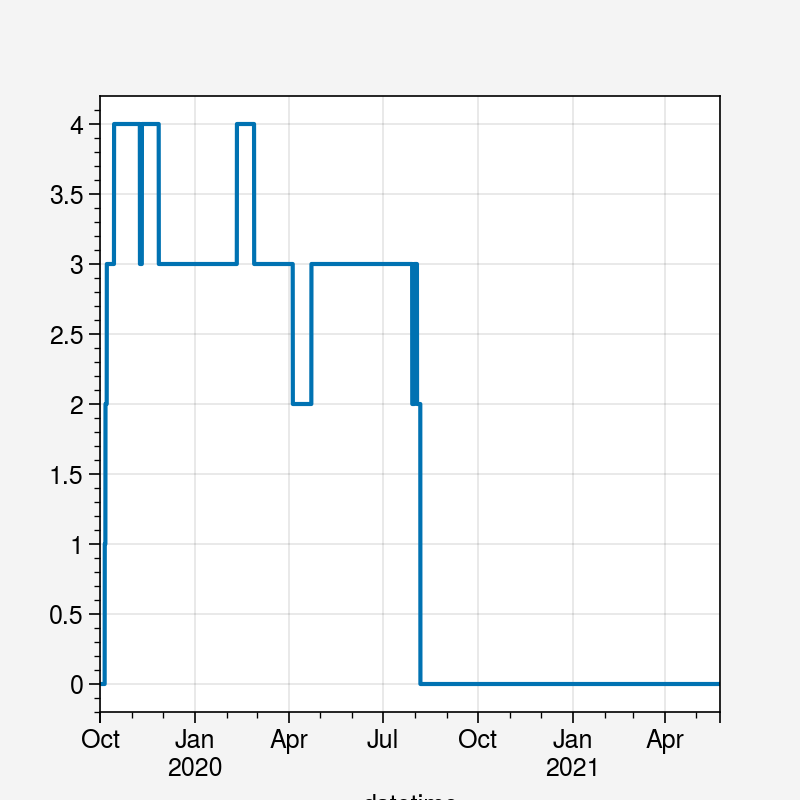

In [21]:
# Just the distances between 'CO1' buoys
#df_x.loc[:, site_buoys['L1']].notnull().sum(axis=1).plot()

In [113]:
order=list(np.hstack([list(site_buoys[x]) for x in site_buoys]))


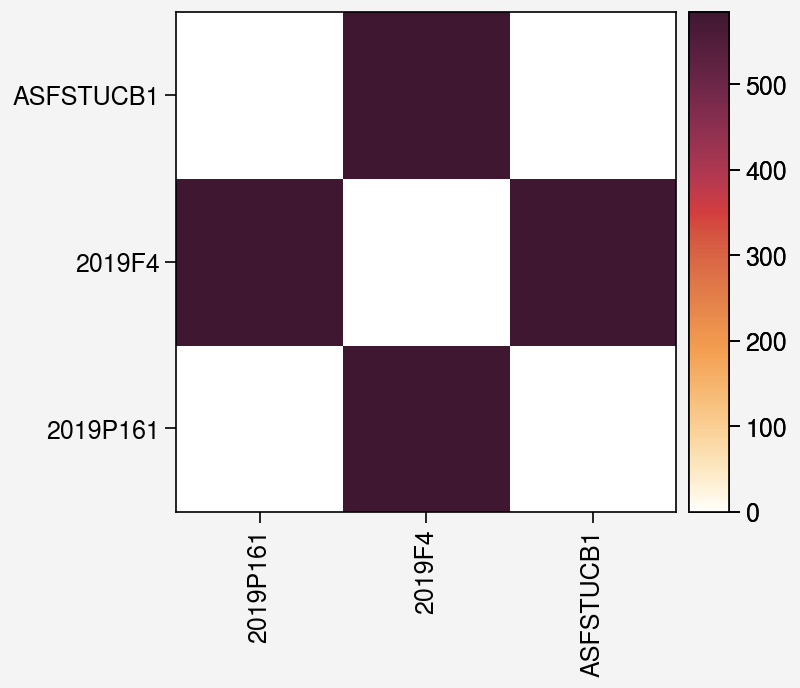

In [111]:
fig, ax = pplt.subplots(width=4)
ax.heatmap(dist.loc[site_buoys['CO1'],  site_buoys['CO1']]/1e3, colorbar='r')
ax.format(xrotation=90)

In [7]:
np.sqrt((X['2019P161'] - X['ASFSTUCB1'])**2 + (Y['2019P161'] - Y['ASFSTUCB1'])**2)

NameError: name 'X' is not defined

In [8]:
dist.loc['2019P161', 'ASFSTUCB1']

NameError: name 'dist' is not defined